# Machine learning - Features extraction

Runs binary and multi-class classifiers on a given dataset.
Dataset are read as Parquet file. The dataset must contain a feature vector named "features" and a classification column.

## Imports

In [1]:
import pandas as pd
import mltoolkit
from pyspark.sql import SparkSession
import numpy as np
import sklearn

## Configure Spark Session

In [2]:
spark = SparkSession.builder \
                    .master("local[*]") \
                    .appName("datasetClassifier") \
                    .getOrCreate()

## Read in data from parquet file

In [3]:
parquetFile = './features/'
data = spark.read.parquet(parquetFile).cache()

df = data.toPandas()
print(f"Total number of data: {df.shape[0]}")
df.head()

Total number of data: 9567


,structureChainId,alpha,beta,coil,foldType,features
0,1RXQ.D,0.662722,0.065089,0.272189,alpha+beta,"[0.1456336055794799, -0.6842364861740399, 0.35..."
1,1RYL.B,0.550336,0.154362,0.295302,alpha+beta,"[0.13782894168629772, -0.765031853847834, 0.69..."
2,1RYO.A,0.367284,0.212963,0.419753,alpha+beta,"[0.19262437658681553, -0.7012773752212524, 0.6..."
3,1RZ3.A,0.423913,0.228261,0.347826,alpha+beta,"[0.16362798592075706, -0.8124300526641309, 0.5..."
4,1RZ4.A,0.676056,0.028169,0.295775,alpha,"[0.023406046255388193, -0.6960803609010247, 0...."


## Select only alpha and beta foldType

In [4]:
df = df[(df.foldType == 'alpha') | (df.foldType == 'beta')]

print(f"Total number of data: {df.shape[0]}")
df.head()

Total number of data: 2390


,structureChainId,alpha,beta,coil,foldType,features
4,1RZ4.A,0.676056,0.028169,0.295775,alpha,"[0.023406046255388193, -0.6960803609010247, 0...."
5,1RZH.L,0.619217,0.035587,0.345196,alpha,"[0.16102126047065082, -0.40389720244732286, 0...."
6,1RZH.M,0.634551,0.039867,0.325581,alpha,"[0.010987468987925502, -0.3211979088343047, 0...."
8,1S0P.B,0.755682,0.011364,0.232955,alpha,"[0.26360149060974697, -0.524667025144611, 0.41..."
13,1S2X.A,0.772222,0.000000,0.227778,alpha,"[0.22360513433558504, -0.5063329056723088, 0.4..."


## Set features to be list of float instead of string 

In [5]:
df.features = df.features.apply(lambda x: np.array(list(x), dtype=np.float))

## Basic dataset information and setting

In [6]:
label = 'foldType'
testFraction = 0.1
seed = 123


vector = df.features.iloc[0]
featureCount = len(vector)
print(f"Feature count    : {featureCount}")

 
classCount = df.foldType.unique().size
print(f"Class count    : {classCount}\n")

  
print(f"Dataset size (unbalanced)    : {df.shape[0]}")
print(df.foldType.value_counts())


df = mltoolkit.downsample(df, 'foldType')
print(f"\nDataset size (balanced)  : {df.shape[0]}")
print(df.foldType.value_counts())

Feature count    : 50
Class count    : 2

Dataset size (unbalanced)    : 2390
alpha    1764
beta      626
Name: foldType, dtype: int64

Dataset size (balanced)  : 1252
beta     626
alpha    626
Name: foldType, dtype: int64


## Random Forest Classifier


 Class	Train	Test

alpha	562	64

beta	564	62

Total time taken: 0.07583093643188477

Methods	RandomForestClassifier
AUC	0.9330897177419355
F Score	0.8305084745762712
Accuracy	0.8412698412698413
Precision	0.875
Recall	0.7903225806451613
False Positive Rate	0.125
True Positive Rate	0.8142857142857143
	
Confusion Matrix
['alpha' 'beta']
[[57  7]
 [13 49]]


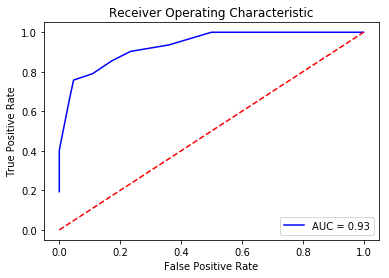

Sample predictions: 


,index,structureChainId,alpha,beta,coil,foldType,features,indexedLabel,predictions
0,1865,4W8Q.A,0.012821,0.534188,0.452991,beta,"[-0.1412204669100615, -0.25700039495385535, 0....",1,beta
1,1048,1YOZ.B,0.724138,0.008621,0.267241,alpha,"[0.458578318744169, -0.6538218234706185, 0.602...",0,alpha
2,4408,4LD1.A,0.000000,0.458599,0.541401,beta,"[0.2577433286071246, -0.5819916785007617, 0.43...",1,beta
3,5675,2CJT.D,0.047244,0.653543,0.299213,beta,"[0.10292825487334854, -0.5196591327683284, 0.4...",1,beta
4,1922,3PF0.A,0.723270,0.006289,0.270440,alpha,"[0.05290609326973024, -0.483856001848319, 0.59...",0,alpha
5,1779,4ATG.A,0.753846,0.000000,0.246154,alpha,"[0.38926946942527324, -0.6163165677529879, 0.4...",0,alpha
6,9164,5KWN.A,0.029412,0.513072,0.457516,beta,"[-0.2023449809554575, -0.4928382865584164, 0.3...",1,beta
7,4412,4LE7.A,0.019685,0.401575,0.578740,beta,"[0.08663940949719538, -0.3453076307623462, 0.3...",1,beta
8,4342,3VJ9.A,0.734328,0.000000,0.265672,alpha,"[0.0794742613118918, -0.6164957742473622, 0.45...",0,alpha
9,8121,1X6I.B,0.678161,0.034483,0.287356,alpha,"[0.05334597678479946, -0.7908739889040589, 0.6...",0,alpha


In [8]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier()
mcc = mltoolkit.MultiClassClassifier(clf, 'foldType', testFraction=0.1)
matrics = mcc.fit(df)
for k,v in matrics.items(): print(f"{k}\t{v}")

# Plot ROC 
mltoolkit.plot_roc(mcc.TPR, mcc.FPR, mcc.AUC)    

print("Sample predictions: ")
mcc.prediction.head(10)

## Logistic Regression Classifier


 Class	Train	Test

alpha	566	60

beta	560	66

Total time taken: 0.026566267013549805

Methods	LogisticRegression
AUC	0.9462121212121211
F Score	0.9104477611940298
Accuracy	0.9047619047619048
Precision	0.8970588235294118
Recall	0.9242424242424242
False Positive Rate	0.10294117647058823
True Positive Rate	0.9137931034482759
	
Confusion Matrix
['alpha' 'beta']
[[53  7]
 [ 5 61]]


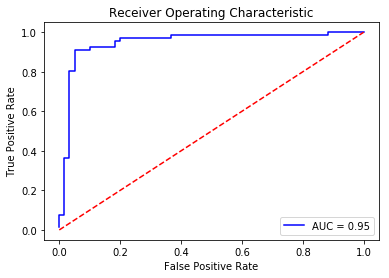

Sample predictions: 


,index,structureChainId,alpha,beta,coil,foldType,features,indexedLabel,predictions
0,1048,1YOZ.B,0.724138,0.008621,0.267241,alpha,"[0.458578318744169, -0.6538218234706185, 0.602...",0,alpha
1,2714,5J1G.B,0.855895,0.000000,0.144105,alpha,"[0.364847543241672, -1.1014970133137039, 0.828...",0,alpha
2,3873,5NOA.A,0.579096,0.028249,0.392655,alpha,"[0.3468054519329024, -0.3236271621610381, 0.57...",0,beta
3,5882,1OGO.X,0.034965,0.424825,0.540210,beta,"[0.004717799051287689, -0.12040586024522781, 0...",1,beta
4,7515,2XZ2.A,0.681818,0.000000,0.318182,alpha,"[0.08050785491672846, -0.7291564041605363, 0.6...",0,alpha
5,2774,3FT1.A,0.000000,0.520000,0.480000,beta,"[0.42422869824098824, -0.6027624467858161, 0.4...",1,beta
6,6206,2B4H.B,0.018349,0.637615,0.344037,beta,"[-0.16074165023068193, -0.3245314491596146, 0....",1,beta
7,5356,5C9L.A,0.000000,0.490085,0.509915,beta,"[-0.12563444076500752, -0.19274454736960647, 0...",1,beta
8,1218,1GUI.A,0.045161,0.522581,0.432258,beta,"[0.06510465981532493, -0.24968262181266562, 0....",1,beta
9,715,1BX7.A,0.000000,0.235294,0.764706,beta,"[0.4431051449781214, -0.45666508569761555, 0.4...",1,beta


In [9]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()
mcc = mltoolkit.MultiClassClassifier(clf, 'foldType', testFraction=0.1)
matrics = mcc.fit(df)
for k,v in matrics.items(): print(f"{k}\t{v}")
    
# Plot ROC 
mltoolkit.plot_roc(mcc.TPR, mcc.FPR, mcc.AUC)
    
print("Sample predictions: ")
mcc.prediction.head(10)

## Simple Multilayer Perception Classifier


 Class	Train	Test

alpha	566	60

beta	560	66

Total time taken: 1.6448252201080322

Methods	MLPClassifier
AUC	0.9613636363636363
F Score	0.9090909090909091
Accuracy	0.9047619047619048
Precision	0.9090909090909091
Recall	0.9090909090909091
False Positive Rate	0.09090909090909091
True Positive Rate	0.9
	
Confusion Matrix
['alpha' 'beta']
[[54  6]
 [ 6 60]]


/home/marshuang80/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)


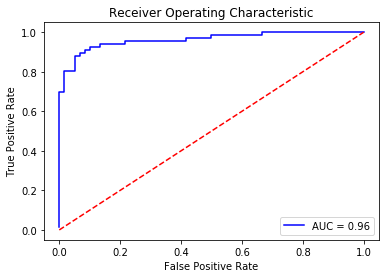

Sample predictions: 


,index,structureChainId,alpha,beta,coil,foldType,features,indexedLabel,predictions
0,3495,5F6L.J,0.000000,0.210526,0.789474,beta,"[0.2806187696181811, -0.8763598073273897, 0.99...",1,alpha
1,5708,5E50.A,0.000000,0.459459,0.540541,beta,"[0.32348509791931557, -0.6729534673927859, 0.4...",1,beta
2,3374,5C4Y.B,0.786765,0.000000,0.213235,alpha,"[0.3635258037069573, -0.8739179377673102, 0.68...",0,alpha
3,6642,3LAG.A,0.000000,0.562500,0.437500,beta,"[-0.07225091306051028, -0.48520515684384047, 0...",1,beta
4,3844,5JLV.D,0.032967,0.670330,0.296703,beta,"[-0.5808048794800736, -0.37869799467895565, 0....",1,beta
5,3117,4BJS.B,0.745455,0.000000,0.254545,alpha,"[0.05993214307818562, -0.8512295640815618, 0.7...",0,alpha
6,71,2P17.A,0.040161,0.578313,0.381526,beta,"[0.1692119094376972, -0.48758190279097663, 0.5...",1,beta
7,3193,5XMZ.A,0.000000,0.622951,0.377049,beta,"[0.12528130878972543, -0.5764769088573658, 0.6...",1,beta
8,1375,3SGR.C,0.000000,0.833333,0.166667,beta,"[0.43625319811205066, -0.3705129226048787, 1.3...",1,beta
9,1070,2EV1.B,0.696133,0.022099,0.281768,alpha,"[-0.27020021394839117, -0.7760174441661232, 0....",0,alpha


In [10]:
from sklearn.neural_network import MLPClassifier

layers = [featureCount, 32, 32, classCount]
clf = MLPClassifier(solver='sgd', \
                    alpha=1e-5, \
                    hidden_layer_sizes = (32, 32))
mcc = mltoolkit.MultiClassClassifier(clf, 'foldType', testFraction=0.1)

matrics = mcc.fit(df)
for k,v in matrics.items(): print(f"{k}\t{v}")
    
# Plot ROC 
mltoolkit.plot_roc(mcc.TPR, mcc.FPR, mcc.AUC)
    
print("Sample predictions: ")
mcc.prediction.head(10)

## Terminate Spark

In [11]:
spark.stop()